In [123]:
# This injects fake planets by (and without using PynPoint)
# 1.  Determining a mask over the host star PSF where nonlinearity/saturation may be an issue
# 2.  Fitting a first PCA basis to the masked host star PSF (using UN-saturated frames as the basis set)
# 3.  Reconstructing the ideal, unsaturated host star PSF for making fake planets
# 4.  Injecting it with a variety of amplitudes/angles around the host star
# 5.  Fitting a second PCA basis to the NON-masked host star PSF (using saturated frames as the basis set)
# 6.  Reconstructing the saturated host star PSF for host star subtraction
# 7.  Subtracting the host star PSF
# 8.  Doing ADI

# created 2019 Jan. 11 by E.S.

## SECTION TO INITIALIZE

In [1]:
import urllib
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage, signal
import sklearn
from sklearn.decomposition import PCA as RandomizedPCA
import time
from matplotlib.colors import LogNorm
import pandas as pd
from regions import PixCoord, CircleSkyRegion, CirclePixelRegion, PolygonPixelRegion

In [2]:
import os
import numpy.ma as ma
from astropy.io import fits
from astropy.modeling import models, fitting

In [3]:
# stem 

stem_base = ('/home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/')
stem_retrieve = (stem_base+'05_centered/') # use frames which have already been centered and are well-behaved, for now
stem_place = (stem_base+'testing/')

In [4]:
# First part reads in a stack of images from which
# 1. host star has been subtracted
# 2. images have been de-rotated
# 3. a fake planet may or may not be present

# So the task here is to 
# 1. median the stack
# 2. convolve the median to smooth it

# ... and, if there is a 

# -> /fake_planet flag: (i.e., we're determining sensitivity)
# 1. given the fake planet location, find its amplitude
# 2. find the stdev of the noise ring 
# 3. count number of other false positives of amplitude >=Nsigma
# 4. calculate false positive fraction (FPF)

# -> /true_data flag: (i.e., we're looking for true candidates)
# 1. do a 2d cross-correlation of the ring with the unsaturated,
#     reconstructed host star PSF (see scipy.signal.correlate2d)
# 2. find where the correlation is maximum
# 3. find the max around that location in the image
# 4. mask that location and find the stdev of the rest of the ring
# 5. if S/N >= Nsigma, flag it!

In [5]:
## ## GENERATE LIST OF FILES IN THE FAKE PLANET / HOST SUBTRACTED DIRECTORY

In [6]:
# Smooth the image, so that the rms calculation will consider PSF-to-PSF variations
# This is the Gaussian smoothing option
'''
sig_y = 9.46 # lambda/D, in pix
sig_x = 3.44 # lambda/B, in pix

smoothed_w_fake_planet = scipy.ndimage.filters.gaussian_filter(star_subted, 
                                                 sigma = np.multiply(0.1,[sig_y, sig_x]), 
                                                 order=0, 
                                                 output=None, 
                                                 mode='reflect', 
                                                 cval=0.0, 
                                                 truncate=4.0)

smoothed_wo_fake_planet = scipy.ndimage.filters.gaussian_filter(star_subted_wo_fake_planet, 
                                                 sigma = np.multiply(0.1,[sig_y, sig_x]), 
                                                 order=0, 
                                                 output=None, 
                                                 mode='reflect', 
                                                 cval=0.0, 
                                                 truncate=4.0)
'''

"\nsig_y = 9.46 # lambda/D, in pix\nsig_x = 3.44 # lambda/B, in pix\n\nsmoothed_w_fake_planet = scipy.ndimage.filters.gaussian_filter(star_subted, \n                                                 sigma = np.multiply(0.1,[sig_y, sig_x]), \n                                                 order=0, \n                                                 output=None, \n                                                 mode='reflect', \n                                                 cval=0.0, \n                                                 truncate=4.0)\n\nsmoothed_wo_fake_planet = scipy.ndimage.filters.gaussian_filter(star_subted_wo_fake_planet, \n                                                 sigma = np.multiply(0.1,[sig_y, sig_x]), \n                                                 order=0, \n                                                 output=None, \n                                                 mode='reflect', \n                                                 cval=0.0, \n   

In [7]:
# read in a test star image

sciImg, header = fits.getdata("lm_180507_009030.fits", header=True)

In [8]:
# read in a test star-subtracted image

star_subted_cube, header = fits.getdata("junk_stack_frames_04259to11000.fits", header=True)
star_subted = np.copy(star_subted_cube[0,:,:])
del star_subted_cube

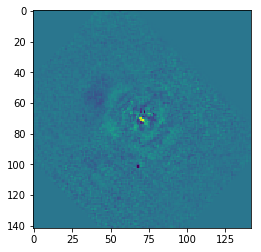

In [9]:
plt.imshow(star_subted)
plt.show()

# Determine location of possible companion, w/o prior knowledge
# (i.e., /true_data flag)

In [10]:
# make a fake image of a companion

fake_sci = np.roll(sciImg, 30, axis=0)
fake_sci = np.roll(fake_sci, 10, axis=1)

In [11]:
# where is the companion in the first place?
# (note that it will be off a bit at phase != 0)

rows_sci, cols_sci = np.where(fake_sci == np.max(fake_sci))
print(rows_sci)
print(cols_sci)

[101]
[84]


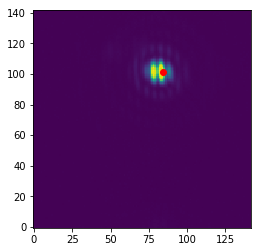

In [12]:
plt.imshow(fake_sci, origin="lower")
plt.scatter(cols_sci, rows_sci, color="red")
plt.show()

In [13]:
# find where fake companion is by correlating with centered PSF

fake_corr = scipy.signal.correlate2d(fake_sci, sciImg, mode="same")

In [14]:
# where is the location of the companion/maximum?

loc_vec = np.where(fake_corr == np.max(fake_corr))

In [15]:
loc_vec

(array([100]), array([80]))

In [16]:
# convert to DataFrame

apparent_comp_vec = pd.DataFrame({"y_pix_coord": loc_vec[0], "x_pix_coord": loc_vec[1]})

In [17]:
apparent_comp_vec

,x_pix_coord,y_pix_coord
0,80,100


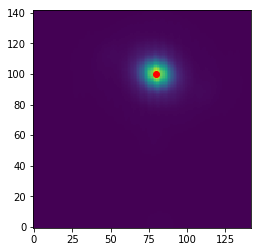

In [18]:
plt.imshow(fake_corr, origin="lower")
plt.scatter(apparent_comp_vec["x_pix_coord"], apparent_comp_vec["y_pix_coord"], color="red")
plt.show()

# Place an aperture over the apparent companion and isolate the noise ring

In [19]:
# Smooth the image, so that the rms calculation will consider PSF-to-PSF variations
# This is the LBT PSF smoothing option

weights = np.divide(sciImg,np.sum(sciImg)) # normalize the host star PSF

smoothed_w_fake_planet = ndimage.filters.convolve(star_subted, 
                                    weights, 
                                    output=None, 
                                    mode='reflect', 
                                    cval=0.0, 
                                    origin=0)

'''
smoothed_wo_fake_planet2 = ndimage.filters.convolve(star_subted_wo_fake_planet, 
                                                   weights, 
                                                   output=None, 
                                                   mode='reflect', 
                                                   cval=0.0, 
                                                   origin=0)
'''

"\nsmoothed_wo_fake_planet2 = ndimage.filters.convolve(star_subted_wo_fake_planet, \n                                                   weights, \n                                                   output=None, \n                                                   mode='reflect', \n                                                   cval=0.0, \n                                                   origin=0)\n"

# Blind search for a companion, signal level

In [90]:
# define circular mask function

def circ_mask(input_array, mask_center, mask_radius, invert=False):
    '''
    Make a circular mask somewhere in the input image (1=good, nan=bad)
    
    INPUTS:
    input_array: the array to mask
    mask_center: the center of the mask, in (y,x) input_array coords
    mask_radius: radius of the mask, in pixels
    invert: if False, area INSIDE mask region is masked; if True, area OUTSIDE
    
    OUTPUTS:
    mask_array: boolean array (1 and nan) of the same size as the input image
    '''
    
    mask_array = np.ones(np.shape(input_array))
    
    y_len = np.arange(np.shape(input_array)[0])
    x_len = np.arange(np.shape(input_array)[1])
    
    xx, yy = np.meshgrid(x_len, y_len)
    
    if invert:
        circ_indices = np.where(np.sqrt(np.power(xx-mask_center[1],2) + 
                                           np.power(yy-mask_center[0],2)) > mask_radius)
    else:
        circ_indices = np.where(np.sqrt(np.power(xx-mask_center[1],2) + 
                                           np.power(yy-mask_center[0],2)) < mask_radius)

    mask_array[circ_indices] = np.nan
    
    return mask_array

In [99]:
pos_num = 0

# define region where fake planet is supposed to be: a circle near (y,x) of injection

comp_rad = 10 # radius of aperture around planet candidate

# N.b. for a 100x100 image, the physical center is at Python coordinate (49.5,49.5)
# i.e., in between pixels 49 and 50 in both dimensions (Python convention),
# or at coordinate (50.5,50.5) in DS9 convention
## ## check this by displacing, flipping, and subtracting to detect asymmetry
x_cen = 0.5*np.shape(smoothed_w_fake_planet)[0]-0.5
y_cen = 0.5*np.shape(smoothed_w_fake_planet)[1]-0.5

# calculate outer noise annulus radius
fake_psf_outer_edge_rad = np.add(np.sqrt(np.power(apparent_comp_vec["x_pix_coord"][pos_num]-x_cen,2) + 
                                  np.power(apparent_comp_vec["y_pix_coord"][pos_num]-y_cen,2)), 
                                  comp_rad)

# calculate inner noise annulus radius
fake_psf_inner_edge_rad = np.subtract(np.sqrt(np.power(apparent_comp_vec["x_pix_coord"][pos_num]-x_cen,2) + 
                                  np.power(apparent_comp_vec["y_pix_coord"][pos_num]-y_cen,2)), 
                                  comp_rad)

# invert-mask the companion
comp_mask_inv = circ_mask(input_array = smoothed_w_fake_planet, 
                      mask_center = [apparent_comp_vec["y_pix_coord"][pos_num],
                                     apparent_comp_vec["x_pix_coord"][pos_num]], 
                      mask_radius = comp_rad, 
                      invert=True)

# invert-mask the noise ring 
noise_mask_outer_inv = circ_mask(input_array = smoothed_w_fake_planet, 
                             mask_center = [y_cen,x_cen], 
                             mask_radius = fake_psf_outer_edge_rad, 
                             invert=True)
noise_mask_inner = circ_mask(input_array = smoothed_w_fake_planet, 
                             mask_center = [y_cen,x_cen], 
                             mask_radius = fake_psf_inner_edge_rad, 
                             invert=False)
comp_mask = circ_mask(input_array = smoothed_w_fake_planet, 
                      mask_center = [apparent_comp_vec["y_pix_coord"][pos_num],
                                     apparent_comp_vec["x_pix_coord"][pos_num]], 
                      mask_radius = comp_rad, 
                      invert=False)

# mask involving the noise ring and without the companion
net_noise_mask = np.add(np.add(noise_mask_inner,noise_mask_outer_inv),comp_mask)

In [105]:
# find S/N

noise_smoothed = np.multiply(smoothed_w_fake_planet,net_noise_mask)
comp_ampl = np.multiply(smoothed_w_fake_planet,comp_mask_inv)

print("Signal:")
print(np.nanmax(comp_ampl))
print("Noise:")
print(np.nanstd(noise_smoothed))

Signal:
97.08212280273438
Noise:
171.25274990135517


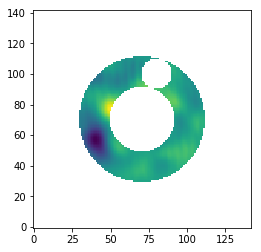

In [102]:
plt.imshow(noise_smoothed, origin="lower")
plt.show()

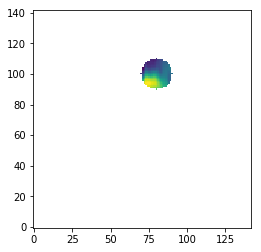

In [104]:
plt.imshow(comp_ampl, origin="lower")
plt.show()

lm_180507_009000_nPCA164.fits


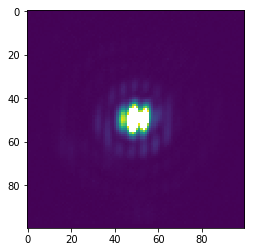

In [42]:
framenum = 9000

#### BELOW FOR FOR LOOP
# fit 2D Gaussian
img_string = 'lm_180507_'+str("{:0>6d}".format(framenum))+'_nPCA164.fits'
    
# if file exists
if os.path.isfile(stem_retrieve+img_string):
        
    # read in image
    sciImg, header = fits.getdata(stem_retrieve+img_string,0,header=True)
        
    print(img_string)
        
    sciImg_masked = np.copy(sciImg)
    mask_threshold = 35000 # pixel counts above this will be masked (refine this later based on linearity data)
    sciImg_masked[sciImg_masked > mask_threshold] = np.nan
        
    #plt.hist(np.ravel(sciImg), bins=1000)
    #plt.xlim([0,5000])
        
    plt.imshow(sciImg_masked)
    plt.show()
    
    # find the PCA spectrum 
    